In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import interpret
from interpret import *
from pathlib import Path

In [3]:
train_df = pd.read_csv('data/train.csv')

In [4]:
train_df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [5]:
# separate into train, valid, and test sets
train_idxs = np.random.choice(len(train_df), int(len(train_df)*0.7), replace=False)
val_idxs = np.arange(len(train_df))
val_idxs = np.setdiff1d(val_idxs, train_idxs)
test_idxs = val_idxs.copy()
val_idxs = np.random.choice(val_idxs, int(len(val_idxs)*0.5), replace=False)
test_idxs = np.setdiff1d(test_idxs, val_idxs)

In [6]:
len(test_idxs), len(val_idxs), len(train_idxs)

(550, 549, 2563)

In [7]:
from enum import Enum

class DataType(Enum):
    Train = 1
    Valid = 2
    Test = 3

In [8]:
from torch.utils.data import Dataset, DataLoader

class DRData(Dataset):
    def __init__(self, data_type, path=Path('data'), tfms=None):
        self.data_type = data_type
        self.path = path
        self.tfms = tfms
        self.df = pd.read_csv(path/'train.csv')
        if data_type == DataType.Train:
            self.idxs = train_idxs
        elif data_type == DataType.Valid:
            self.idxs = val_idxs
        elif data_type == DataType.Test:
            self.idxs = test_idxs
        else:
            raise Exception(f"data_type must be a {DataType}")
            
        
    def __getitem__(self, idx):
        i = self.idxs[idx]
        filename, label = self.df.iloc[i]
        img = Image.open(self.path/"images"/(filename+".png"))
        if self.tfms is not None:
            img = tfms(img)
        return img, label
    
    def __len__(self):
        return len(self.idxs)
    
    def show(self, num=9, figsize=(8,8), random=False):
        r = math.ceil(math.sqrt(num))
        axes = plt.subplots(r,r,figsize=figsize)[1].flatten()
        for i,ax in enumerate(axes):
            if i<num:
                im,label = self[np.random.randint(len(self))] if random else self[i]
                ax.imshow(im)
                ax.set_title(f'{label}')
            ax.set_axis_off()
        
    @staticmethod
    def decode_label(lb):
        labels = {0: "None", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Prolifertive"}
        return labels[lb]

In [23]:
ds = DRData(DataType.Train)

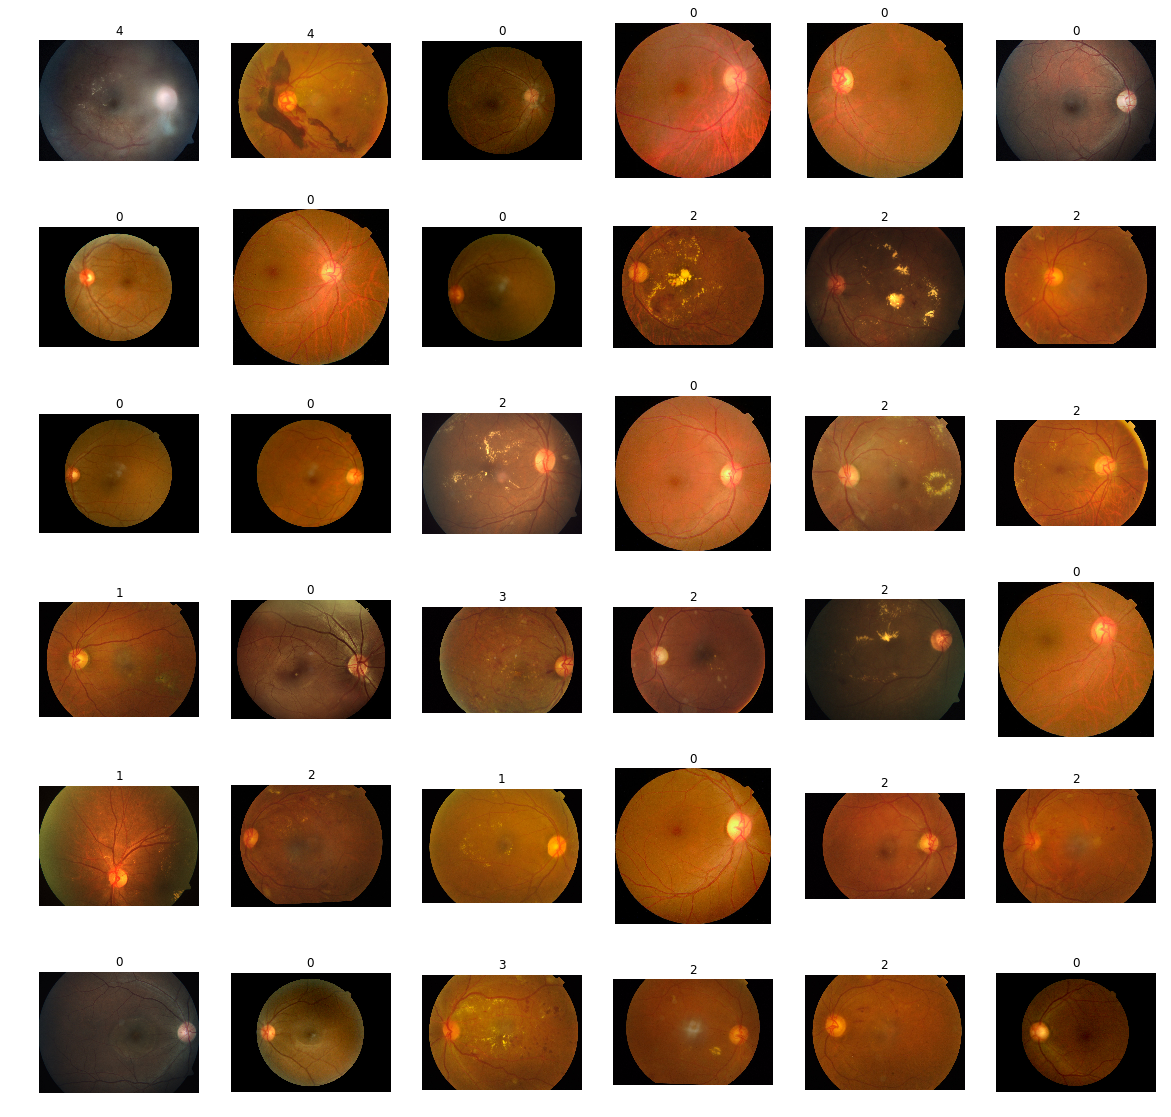

In [25]:
ds.show(36, random=True, figsize=(20,20))

## Train a Classifier

In [26]:
model = torchvision.models.resnet34(pretrained=False)

In [27]:
tfms = interpret.get_transforms(32, rotate=None, flip_hor=False, perspective=False, color_jitter=False)

In [28]:
ds = DRData(DataType.Train, tfms=tfms)
dl = DataLoader(ds, batch_size=256, num_workers=8, pin_memory=True)
l = Learner(dl, model)

In [89]:
%%time
l.fit(5, 1e-3)

0 - loss: 4.966  accuracy: 0.476
1 - loss: 1.255  accuracy: 0.673
2 - loss: 1.159  accuracy: 0.621
3 - loss: 1.044  accuracy: 0.635
4 - loss: 1.353  accuracy: 0.639


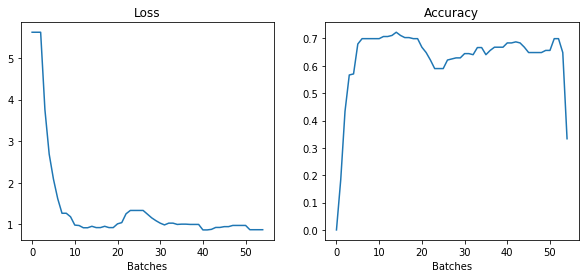

In [92]:
l.plot(smooth=True)

In [104]:
l.save('res34-1')

In [29]:
l.load('res34-1')

## Interpret

### GradCAM

In [42]:
im, lb = ds[5]
print(f"Image Label: {lb} - {ds.decode_label(lb)}")

Image Label: 0 - None


In [43]:
model.eval()
preds = model(im[None]).argmax(1)
print(f"Prediction: {preds.item()} - {ds.decode_label(preds.item())}")

Prediction: 0 - None


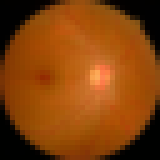

In [44]:
zoom(denorm(im),5)

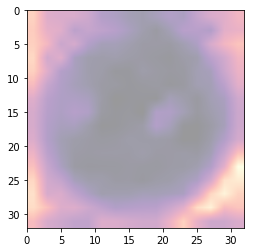

In [45]:
interpret.gradcam(model, im[None], im_class=2, layer=2, show_im=False);

### Visualisations